# Implementing a Low Rank Adapter (LoRA) (8 points)

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References: 

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [22]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms
import math

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [2]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST 
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 54528025.87it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39247562.01it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [4]:
#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()
        
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()
        
        
        self.dropout = nn.Dropout(0.5)



    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [5]:
#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

#to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
#so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()
    
    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation')
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())
    
    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)
            
        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)
        
    return train_loss_lst, val_loss_lst

In [6]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst,label="train")
    plt.plot(val_loss_lst,label="val")
    plt.legend()

# If you have GPU access, or simply want to train your own model, run this code

In [7]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

Training: 100%|██████████| 168/168 [00:08<00:00, 18.83it/s, loss=0.15] 


Epoch [1/30] Train Loss: 0.15009916924671934


Validation: 100%|██████████| 72/72 [00:02<00:00, 35.71it/s, loss=0.0698]


Epoch [1/30] Validation Loss: 0.06977424311399874


Training: 100%|██████████| 168/168 [00:07<00:00, 22.31it/s, loss=0.0679]


Epoch [2/30] Train Loss: 0.06792992858737264


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.48it/s, loss=0.0454]


Epoch [2/30] Validation Loss: 0.045439073136852436


Training: 100%|██████████| 168/168 [00:07<00:00, 22.57it/s, loss=0.0578]


Epoch [3/30] Train Loss: 0.057823804390084534


Validation: 100%|██████████| 72/72 [00:01<00:00, 36.88it/s, loss=0.0479]


Epoch [3/30] Validation Loss: 0.047899010592825815


Training: 100%|██████████| 168/168 [00:07<00:00, 22.06it/s, loss=0.0536]


Epoch [4/30] Train Loss: 0.053565562780325614


Validation: 100%|██████████| 72/72 [00:01<00:00, 36.82it/s, loss=0.0398]


Epoch [4/30] Validation Loss: 0.03975901216714798


Training: 100%|██████████| 168/168 [00:07<00:00, 22.09it/s, loss=0.0427]


Epoch [5/30] Train Loss: 0.04270482809876003


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.04it/s, loss=0.0407]


Epoch [5/30] Validation Loss: 0.04067894562225168


Training: 100%|██████████| 168/168 [00:07<00:00, 22.42it/s, loss=0.0416]


Epoch [6/30] Train Loss: 0.04164662334785264


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.41it/s, loss=0.0421]


Epoch [6/30] Validation Loss: 0.04214535740660116


Training: 100%|██████████| 168/168 [00:07<00:00, 22.56it/s, loss=0.0364]


Epoch [7/30] Train Loss: 0.036436328010278796


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.50it/s, loss=0.0431]


Epoch [7/30] Validation Loss: 0.04305017044801692


Training: 100%|██████████| 168/168 [00:07<00:00, 22.07it/s, loss=0.0401]


Epoch [8/30] Train Loss: 0.04009803732749008


Validation: 100%|██████████| 72/72 [00:02<00:00, 35.57it/s, loss=0.0401]


Epoch [8/30] Validation Loss: 0.04012401053963307


Training: 100%|██████████| 168/168 [00:07<00:00, 21.18it/s, loss=0.0287]


Epoch [9/30] Train Loss: 0.02867938498023986


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.30it/s, loss=0.0374]


Epoch [9/30] Validation Loss: 0.03739307412534901


Training: 100%|██████████| 168/168 [00:07<00:00, 22.35it/s, loss=0.0228]


Epoch [10/30] Train Loss: 0.022814404167331218


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.65it/s, loss=0.0399]


Epoch [10/30] Validation Loss: 0.03986481132940551


Training: 100%|██████████| 168/168 [00:07<00:00, 22.33it/s, loss=0.0296]


Epoch [11/30] Train Loss: 0.029635087339210303


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.27it/s, loss=0.04]  


Epoch [11/30] Validation Loss: 0.04002867037909002


Training: 100%|██████████| 168/168 [00:07<00:00, 22.79it/s, loss=0.0268]


Epoch [12/30] Train Loss: 0.02682540976439625


Validation: 100%|██████████| 72/72 [00:01<00:00, 36.88it/s, loss=0.0408]


Epoch [12/30] Validation Loss: 0.04080077446087671


Training: 100%|██████████| 168/168 [00:07<00:00, 22.77it/s, loss=0.0377]


Epoch [13/30] Train Loss: 0.03774832795343606


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.61it/s, loss=0.0421]


Epoch [13/30] Validation Loss: 0.04207517784056512


Training: 100%|██████████| 168/168 [00:07<00:00, 22.75it/s, loss=0.0268]


Epoch [14/30] Train Loss: 0.026769050542151535


Validation: 100%|██████████| 72/72 [00:01<00:00, 36.89it/s, loss=0.0561]


Epoch [14/30] Validation Loss: 0.0561247451292325


Training: 100%|██████████| 168/168 [00:07<00:00, 22.46it/s, loss=0.0257]


Epoch [15/30] Train Loss: 0.02569897004988369


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.22it/s, loss=0.0536]


Epoch [15/30] Validation Loss: 0.05355367387043467


Training: 100%|██████████| 168/168 [00:07<00:00, 22.85it/s, loss=0.0252]


Epoch [16/30] Train Loss: 0.025203631639150053


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.71it/s, loss=0.0415]


Epoch [16/30] Validation Loss: 0.04147526184109059


Training: 100%|██████████| 168/168 [00:07<00:00, 22.90it/s, loss=0.0286]


Epoch [17/30] Train Loss: 0.028630602830941956


Validation: 100%|██████████| 72/72 [00:01<00:00, 38.04it/s, loss=0.0393] 


Epoch [17/30] Validation Loss: 0.039340921186117664


Training: 100%|██████████| 168/168 [00:07<00:00, 22.85it/s, loss=0.0254]


Epoch [18/30] Train Loss: 0.025426168532205685


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.64it/s, loss=0.0456]


Epoch [18/30] Validation Loss: 0.04563406602255782


Training: 100%|██████████| 168/168 [00:07<00:00, 22.88it/s, loss=0.0248]


Epoch [19/30] Train Loss: 0.024775865471578333


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.74it/s, loss=0.0568]


Epoch [19/30] Validation Loss: 0.05682236559015211


Training: 100%|██████████| 168/168 [00:07<00:00, 22.83it/s, loss=0.0255]


Epoch [20/30] Train Loss: 0.025536355390656917


Validation: 100%|██████████| 72/72 [00:01<00:00, 36.09it/s, loss=0.0436]


Epoch [20/30] Validation Loss: 0.043617685242881836


Training: 100%|██████████| 168/168 [00:07<00:00, 22.71it/s, loss=0.0265]


Epoch [21/30] Train Loss: 0.02653093807783166


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.58it/s, loss=0.0433]


Epoch [21/30] Validation Loss: 0.04325047029404535


Training: 100%|██████████| 168/168 [00:07<00:00, 22.76it/s, loss=0.0319]


Epoch [22/30] Train Loss: 0.031893947231981745


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.80it/s, loss=0.0417]


Epoch [22/30] Validation Loss: 0.04174205588383807


Training: 100%|██████████| 168/168 [00:07<00:00, 22.80it/s, loss=0.0248]


Epoch [23/30] Train Loss: 0.024809059077559443


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.73it/s, loss=0.0371]


Epoch [23/30] Validation Loss: 0.03708961962729518


Training: 100%|██████████| 168/168 [00:07<00:00, 22.91it/s, loss=0.0205]


Epoch [24/30] Train Loss: 0.020477721448644712


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.90it/s, loss=0.0562]


Epoch [24/30] Validation Loss: 0.05618613905062375


Training: 100%|██████████| 168/168 [00:07<00:00, 22.84it/s, loss=0.0224]


Epoch [25/30] Train Loss: 0.022354343388412547


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.61it/s, loss=0.0562]


Epoch [25/30] Validation Loss: 0.05618777913322345


Training: 100%|██████████| 168/168 [00:07<00:00, 22.67it/s, loss=0.0223]


Epoch [26/30] Train Loss: 0.022280228274428823


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.50it/s, loss=0.0389]


Epoch [26/30] Validation Loss: 0.038861031920722176


Training: 100%|██████████| 168/168 [00:07<00:00, 22.73it/s, loss=0.0223]


Epoch [27/30] Train Loss: 0.022336321440715914


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.54it/s, loss=0.0421]


Epoch [27/30] Validation Loss: 0.04210708007942938


Training: 100%|██████████| 168/168 [00:07<00:00, 22.77it/s, loss=0.0174]


Epoch [28/30] Train Loss: 0.017357970578034707


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.21it/s, loss=0.0511]


Epoch [28/30] Validation Loss: 0.05107505403975665


Training: 100%|██████████| 168/168 [00:07<00:00, 22.75it/s, loss=0.0248]


Epoch [29/30] Train Loss: 0.024826526697498116


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.43it/s, loss=0.0441]


Epoch [29/30] Validation Loss: 0.044056568654493984


Training: 100%|██████████| 168/168 [00:07<00:00, 22.84it/s, loss=0.0205]


Epoch [30/30] Train Loss: 0.020474981853892262


Validation: 100%|██████████| 72/72 [00:01<00:00, 37.68it/s, loss=0.0716]

Epoch [30/30] Validation Loss: 0.07163749834459547


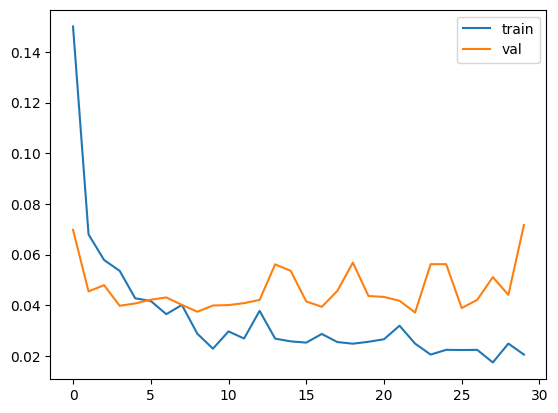

In [8]:
plot_losses(train_loss_lst,val_loss_lst)

In [9]:
# save the model
path1= "./models/model.pth"
torch.save(net,path1)

path2= "./models/model_state_dict.pth"
# Save the state dictionary
torch.save(net.state_dict(), path2)

# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/ 


In [10]:
net=torch.load(path1).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [11]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [12]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')


Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [13]:
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0
    
    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1
                    
                total += 1

    accuracy = round(correct / total, 3)
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')
        
    return accuracy

test(test_loader, "Testing", net, {i: 0 for i in range(5)})


Testing: 100%|██████████| 41/41 [00:01<00:00, 34.78it/s]

Accuracy: 0.988
Wrong counts for the digit 0: 7
Wrong counts for the digit 1: 10
Wrong counts for the digit 2: 12
Wrong counts for the digit 3: 10
Wrong counts for the digit 4: 24


0.988

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [14]:
#same code as before except for the mask

# create a mask to filter indices for each label, retrieve digits 5...9
class_names_subset2 = [5, 6, 7, 8, 9]
train_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)


# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [15]:
wrong_counts_subset2 = {i: 0 for i in range(5, 10)}
accuracy_subset2 = test(test_loader_subset2, "Testing subset2", net, wrong_counts_subset2)

Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 35.05it/s]


Accuracy: 0.384
Wrong counts for the digit 5: 803
Wrong counts for the digit 6: 949
Wrong counts for the digit 7: 431
Wrong counts for the digit 8: 498
Wrong counts for the digit 9: 311


# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

In [19]:
# Fine-tune the model on digits 5...9
train_loss_lst_subset2, val_loss_lst_subset2 = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)

# Evaluate the fine-tuned model on the test set of digits 5...9
wrong_counts_subset2_finetuned = {i: 0 for i in range(5, 10)}
accuracy_subset2_finetuned = test(test_loader_subset2, "Testing subset2", net, wrong_counts_subset2_finetuned)

Training: 100%|██████████| 161/161 [00:07<00:00, 21.23it/s, loss=0.339]


Epoch [1/10] Train Loss: 0.3387399989625682


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.94it/s, loss=0.225]


Epoch [1/10] Validation Loss: 0.2249860457968021


Training: 100%|██████████| 161/161 [00:07<00:00, 21.64it/s, loss=0.302]


Epoch [2/10] Train Loss: 0.3024372586182186


Validation: 100%|██████████| 69/69 [00:01<00:00, 36.53it/s, loss=0.203]


Epoch [2/10] Validation Loss: 0.20275772838056952


Training: 100%|██████████| 161/161 [00:07<00:00, 21.69it/s, loss=0.271]


Epoch [3/10] Train Loss: 0.271147960785383


Validation: 100%|██████████| 69/69 [00:01<00:00, 36.78it/s, loss=0.186]


Epoch [3/10] Validation Loss: 0.1862616754960323


Training: 100%|██████████| 161/161 [00:07<00:00, 20.59it/s, loss=0.253]


Epoch [4/10] Train Loss: 0.2534215155503024


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.25it/s, loss=0.173]


Epoch [4/10] Validation Loss: 0.172812109840089


Training: 100%|██████████| 161/161 [00:07<00:00, 20.92it/s, loss=0.237]


Epoch [5/10] Train Loss: 0.23707125590454717


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.89it/s, loss=0.162]


Epoch [5/10] Validation Loss: 0.16213689226171243


Training: 100%|██████████| 161/161 [00:07<00:00, 21.69it/s, loss=0.224]


Epoch [6/10] Train Loss: 0.22399628139245584


Validation: 100%|██████████| 69/69 [00:01<00:00, 36.47it/s, loss=0.152]


Epoch [6/10] Validation Loss: 0.15225070455799933


Training: 100%|██████████| 161/161 [00:07<00:00, 22.09it/s, loss=0.209]


Epoch [7/10] Train Loss: 0.20932224258687926


Validation: 100%|██████████| 69/69 [00:01<00:00, 36.74it/s, loss=0.144]


Epoch [7/10] Validation Loss: 0.1444603996756284


Training: 100%|██████████| 161/161 [00:07<00:00, 22.15it/s, loss=0.199]


Epoch [8/10] Train Loss: 0.1985427241610444


Validation: 100%|██████████| 69/69 [00:01<00:00, 36.61it/s, loss=0.137]


Epoch [8/10] Validation Loss: 0.13700158872466156


Training: 100%|██████████| 161/161 [00:07<00:00, 22.06it/s, loss=0.186]


Epoch [9/10] Train Loss: 0.186175936728901


Validation: 100%|██████████| 69/69 [00:01<00:00, 36.92it/s, loss=0.131]


Epoch [9/10] Validation Loss: 0.13067758984971736


Training: 100%|██████████| 161/161 [00:07<00:00, 22.02it/s, loss=0.181]


Epoch [10/10] Train Loss: 0.18135264805107384


Validation: 100%|██████████| 69/69 [00:01<00:00, 36.49it/s, loss=0.125]


Epoch [10/10] Validation Loss: 0.1250893547591092


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 36.64it/s]

Accuracy: 0.959
Wrong counts for the digit 5: 44
Wrong counts for the digit 6: 24
Wrong counts for the digit 7: 38
Wrong counts for the digit 8: 46
Wrong counts for the digit 9: 45


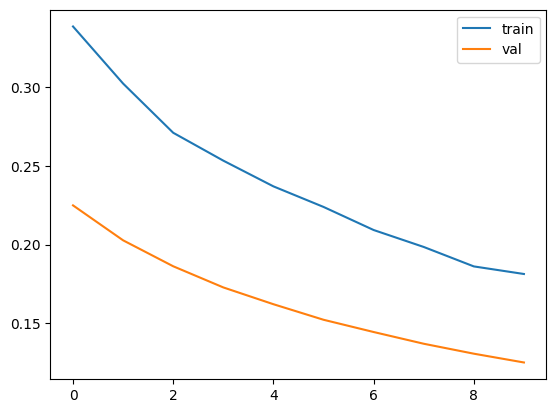

In [20]:
#plot the train and validation losses
plot_losses(train_loss_lst_subset2, val_loss_lst_subset2)

In [21]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot

# Test accuracy of fine-tuned model on digits 5...9
wrong_counts_subset2_finetuned = {i: 0 for i in range(5, 10)}
accuracy_subset2_finetuned = test(test_loader_subset2, "Testing subset2", net, wrong_counts_subset2_finetuned)

# Save the accuracy value into a variable for the final plot
accuracy_finetuned_all = accuracy_subset2_finetuned

Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 35.82it/s]

Accuracy: 0.959
Wrong counts for the digit 5: 44
Wrong counts for the digit 6: 24
Wrong counts for the digit 7: 38
Wrong counts for the digit 8: 46
Wrong counts for the digit 9: 45


# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

In [29]:
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()
        
        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2))
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)
        
        # Define lora hyperparameters
        self.lora_rank = lora_rank
        self.lora_alpha = 16
        self.lora_dropout = nn.Dropout(0.1)  # Create an instance of nn.Dropout
        
       
        # Define lora weights matrices for each layer in pretrained model
        self.l1_lora_A = nn.Parameter(torch.zeros(self.lora_rank, self.pretrained_net.linear1.in_features))
        self.l1_lora_B = nn.Parameter(torch.zeros(self.pretrained_net.linear1.out_features, self.lora_rank))
        self.l2_lora_A = nn.Parameter(torch.zeros(self.lora_rank, self.pretrained_net.linear2.in_features))
        self.l2_lora_B = nn.Parameter(torch.zeros(self.pretrained_net.linear2.out_features, self.lora_rank))
        self.l3_lora_A = nn.Parameter(torch.zeros(self.lora_rank, self.pretrained_net.linear3.in_features))
        self.l3_lora_B = nn.Parameter(torch.zeros(self.pretrained_net.linear3.out_features, self.lora_rank))
       
        # Initialization for lora layers
        nn.init.kaiming_uniform_(self.l1_lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.l1_lora_B)
        nn.init.kaiming_uniform_(self.l2_lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.l2_lora_B)
        nn.init.kaiming_uniform_(self.l3_lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.l3_lora_B)
                   
        # Freeze non-LoRA weights
        for param in self.pretrained_net.parameters():
            param.requires_grad = False
                
    def lora_linear(self, x, layer, lora_A, lora_B):
        # Implement formula (3) in arxiv.org/pdf/2106.09685.pdf
        h = layer(x) + (self.lora_dropout(x) @ lora_A.T @ lora_B.T) * self.lora_alpha / self.lora_rank
        return h
                     
        
    def forward(self, input):
        x = input.view(-1, 28*28)
        
        # Layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Layer 2 (hidden size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Layer 3 (hidden size, output size)
        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B)
        
        return x

lora_rank=1
# Create an instance of the modified network
modified_net = ModifiedClassifier(lora_rank).to(device)


Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

In [30]:
# Count the parameters introduced by lora layers
def count_lora_parameters(model):
    lora_parameters = [
        model.l1_lora_A,
        model.l1_lora_B,
        model.l2_lora_A,
        model.l2_lora_B,
        model.l3_lora_A,
        model.l3_lora_B
    ]
    
    total_lora_params = 0
    for param in lora_parameters:
        total_lora_params += torch.numel(param)
    
    return total_lora_params

lora_params_count = count_lora_parameters(modified_net)
print(f"Number of parameters introduced by LoRA: {lora_params_count}")

Number of parameters introduced by LoRA: 6789


# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

In [31]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
train_loss_lst_lora_rank1, val_loss_lst_lora_rank1 = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)

Training: 100%|██████████| 161/161 [00:05<00:00, 27.36it/s, loss=7.6] 


Epoch [1/10] Train Loss: 7.5951009122481254


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.02it/s, loss=6.82]


Epoch [1/10] Validation Loss: 6.822700327721195


Training: 100%|██████████| 161/161 [00:05<00:00, 28.28it/s, loss=7.36]


Epoch [2/10] Train Loss: 7.359691833116994


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.34it/s, loss=6.47]


Epoch [2/10] Validation Loss: 6.471307761427285


Training: 100%|██████████| 161/161 [00:05<00:00, 28.13it/s, loss=6.83]


Epoch [3/10] Train Loss: 6.826205087744671


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.30it/s, loss=5.86]


Epoch [3/10] Validation Loss: 5.861929064211638


Training: 100%|██████████| 161/161 [00:05<00:00, 27.91it/s, loss=6.1] 


Epoch [4/10] Train Loss: 6.1021380143135975


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.97it/s, loss=5.05]


Epoch [4/10] Validation Loss: 5.047599806301836


Training: 100%|██████████| 161/161 [00:05<00:00, 28.10it/s, loss=5.19]


Epoch [5/10] Train Loss: 5.189862180200422


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.94it/s, loss=4.08]


Epoch [5/10] Validation Loss: 4.079368494559025


Training: 100%|██████████| 161/161 [00:05<00:00, 27.54it/s, loss=4.15]


Epoch [6/10] Train Loss: 4.153553893107064


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.33it/s, loss=3.07]


Epoch [6/10] Validation Loss: 3.0708941825921983


Training: 100%|██████████| 161/161 [00:05<00:00, 28.34it/s, loss=3.16]


Epoch [7/10] Train Loss: 3.1592721583680334


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.88it/s, loss=2.27]


Epoch [7/10] Validation Loss: 2.2722896475722822


Training: 100%|██████████| 161/161 [00:05<00:00, 28.11it/s, loss=2.44]


Epoch [8/10] Train Loss: 2.441297033558721


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.71it/s, loss=1.74]


Epoch [8/10] Validation Loss: 1.743134819942972


Training: 100%|██████████| 161/161 [00:05<00:00, 28.16it/s, loss=1.93]


Epoch [9/10] Train Loss: 1.930206002655977


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.94it/s, loss=1.37]


Epoch [9/10] Validation Loss: 1.3734580235204834


Training: 100%|██████████| 161/161 [00:05<00:00, 28.10it/s, loss=1.55]


Epoch [10/10] Train Loss: 1.5453042650815123


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.44it/s, loss=1.16]

Epoch [10/10] Validation Loss: 1.158852488234423


In [32]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"
for name, param in modified_net.pretrained_net.named_parameters():
    assert torch.equal(param, original_weights[name]), f"Frozen parameter {name} has changed during fine-tuning!"

print("Frozen parameters remained unchanged during fine-tuning.")

Frozen parameters remained unchanged during fine-tuning.


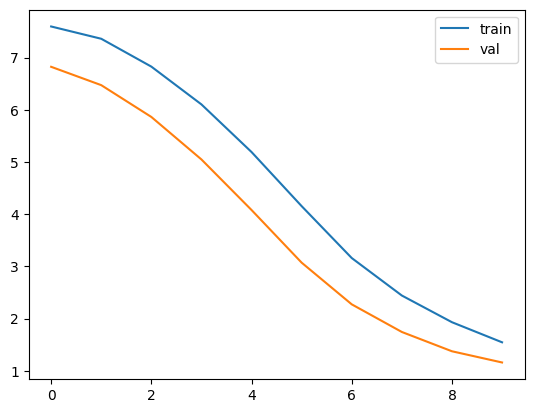

In [34]:
#plot losses
plot_losses(train_loss_lst_lora_rank1, val_loss_lst_lora_rank1)

In [35]:
#Compute test accuracy on MNIST 5...9 for that lora rank
wrong_counts_subset2_lora_rank1 = {i: 0 for i in range(5, 10)}
accuracy_subset2_lora_rank1 = test(test_loader_subset2, "Testing subset2", modified_net, wrong_counts_subset2_lora_rank1)
print(f"Test accuracy on MNIST 5...9 for LoRA rank 1: {accuracy_subset2_lora_rank1}")

Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 35.77it/s]

Accuracy: 0.709
Wrong counts for the digit 5: 434
Wrong counts for the digit 6: 288
Wrong counts for the digit 7: 255
Wrong counts for the digit 8: 224
Wrong counts for the digit 9: 213
Test accuracy on MNIST 5...9 for LoRA rank 1: 0.709


# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added 

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9 

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

Fine-tuning with LoRA rank 1


Training: 100%|██████████| 161/161 [00:05<00:00, 27.38it/s, loss=7.59]


Epoch [1/10] Train Loss: 7.586478091174771


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.01it/s, loss=6.78]


Epoch [1/10] Validation Loss: 6.779204334037892


Training: 100%|██████████| 161/161 [00:05<00:00, 27.27it/s, loss=7.35]


Epoch [2/10] Train Loss: 7.349637843066861


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.75it/s, loss=6.43]


Epoch [2/10] Validation Loss: 6.42972763724949


Training: 100%|██████████| 161/161 [00:05<00:00, 27.39it/s, loss=6.86]


Epoch [3/10] Train Loss: 6.861848383956814


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.36it/s, loss=5.9] 


Epoch [3/10] Validation Loss: 5.897553354069807


Training: 100%|██████████| 161/161 [00:05<00:00, 27.16it/s, loss=6.24]


Epoch [4/10] Train Loss: 6.235832744503614


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.71it/s, loss=5.26]


Epoch [4/10] Validation Loss: 5.257520965907885


Training: 100%|██████████| 161/161 [00:05<00:00, 27.26it/s, loss=5.49]


Epoch [5/10] Train Loss: 5.491784020240263


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.66it/s, loss=4.57]


Epoch [5/10] Validation Loss: 4.567508773527283


Training: 100%|██████████| 161/161 [00:05<00:00, 27.54it/s, loss=4.79]


Epoch [6/10] Train Loss: 4.790519666967925


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.64it/s, loss=3.83]


Epoch [6/10] Validation Loss: 3.830215447190879


Training: 100%|██████████| 161/161 [00:05<00:00, 27.95it/s, loss=3.94]


Epoch [7/10] Train Loss: 3.935255828111068


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.19it/s, loss=3.04]


Epoch [7/10] Validation Loss: 3.0391230859618257


Training: 100%|██████████| 161/161 [00:05<00:00, 28.27it/s, loss=3.08]


Epoch [8/10] Train Loss: 3.078543944388443


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.73it/s, loss=2.18]


Epoch [8/10] Validation Loss: 2.1750969282094985


Training: 100%|██████████| 161/161 [00:05<00:00, 27.41it/s, loss=2.22]


Epoch [9/10] Train Loss: 2.2202521436703133


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.21it/s, loss=1.55]


Epoch [9/10] Validation Loss: 1.5465000660523125


Training: 100%|██████████| 161/161 [00:05<00:00, 27.95it/s, loss=1.73]


Epoch [10/10] Train Loss: 1.7252701543132711


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.35it/s, loss=1.23]


Epoch [10/10] Validation Loss: 1.2322710579720095


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 34.68it/s]


Accuracy: 0.699
Wrong counts for the digit 5: 362
Wrong counts for the digit 6: 333
Wrong counts for the digit 7: 253
Wrong counts for the digit 8: 312
Wrong counts for the digit 9: 204
Test accuracy on MNIST 5...9 for LoRA rank 1: 0.699
Number of parameters introduced by LoRA rank 1: 6789
---
Fine-tuning with LoRA rank 2


Training: 100%|██████████| 161/161 [00:05<00:00, 27.02it/s, loss=7.58]


Epoch [1/10] Train Loss: 7.575793180406464


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.55it/s, loss=6.78]


Epoch [1/10] Validation Loss: 6.78419093809266


Training: 100%|██████████| 161/161 [00:05<00:00, 26.96it/s, loss=7.34]


Epoch [2/10] Train Loss: 7.339846166764727


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.76it/s, loss=6.38]


Epoch [2/10] Validation Loss: 6.380282650823179


Training: 100%|██████████| 161/161 [00:06<00:00, 25.85it/s, loss=6.75]


Epoch [3/10] Train Loss: 6.753496922321201


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.29it/s, loss=5.74]


Epoch [3/10] Validation Loss: 5.744590904401696


Training: 100%|██████████| 161/161 [00:06<00:00, 25.57it/s, loss=5.98]


Epoch [4/10] Train Loss: 5.975405935915361


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.95it/s, loss=4.93]


Epoch [4/10] Validation Loss: 4.9289228017779365


Training: 100%|██████████| 161/161 [00:06<00:00, 25.07it/s, loss=5.05]


Epoch [5/10] Train Loss: 5.047823380239262


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.29it/s, loss=3.98]


Epoch [5/10] Validation Loss: 3.9828235757523687


Training: 100%|██████████| 161/161 [00:06<00:00, 26.05it/s, loss=4.05]


Epoch [6/10] Train Loss: 4.052776357401973


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.15it/s, loss=3.01]


Epoch [6/10] Validation Loss: 3.0113708489183066


Training: 100%|██████████| 161/161 [00:06<00:00, 25.65it/s, loss=3.16]


Epoch [7/10] Train Loss: 3.1559828660502935


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.13it/s, loss=2.3] 


Epoch [7/10] Validation Loss: 2.2984237981879194


Training: 100%|██████████| 161/161 [00:06<00:00, 25.32it/s, loss=2.52]


Epoch [8/10] Train Loss: 2.5246800443400508


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.27it/s, loss=1.86]


Epoch [8/10] Validation Loss: 1.8617111703623896


Training: 100%|██████████| 161/161 [00:06<00:00, 24.95it/s, loss=2.1] 


Epoch [9/10] Train Loss: 2.0987126138639747


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.10it/s, loss=1.53]


Epoch [9/10] Validation Loss: 1.52673015559929


Training: 100%|██████████| 161/161 [00:05<00:00, 27.86it/s, loss=1.74]


Epoch [10/10] Train Loss: 1.7384716894315637


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.69it/s, loss=1.26]


Epoch [10/10] Validation Loss: 1.2630349630894868


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 34.90it/s]


Accuracy: 0.633
Wrong counts for the digit 5: 369
Wrong counts for the digit 6: 192
Wrong counts for the digit 7: 238
Wrong counts for the digit 8: 742
Wrong counts for the digit 9: 243
Test accuracy on MNIST 5...9 for LoRA rank 2: 0.633
Number of parameters introduced by LoRA rank 2: 13578
---
Fine-tuning with LoRA rank 4


Training: 100%|██████████| 161/161 [00:06<00:00, 26.73it/s, loss=7.62]


Epoch [1/10] Train Loss: 7.624980384518641


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.47it/s, loss=6.8] 


Epoch [1/10] Validation Loss: 6.800770711207735


Training: 100%|██████████| 161/161 [00:06<00:00, 26.82it/s, loss=7.34]


Epoch [2/10] Train Loss: 7.340159499126932


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.29it/s, loss=6.46]


Epoch [2/10] Validation Loss: 6.460422750832378


Training: 100%|██████████| 161/161 [00:05<00:00, 27.80it/s, loss=6.95]


Epoch [3/10] Train Loss: 6.953423251276431


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.32it/s, loss=5.93]


Epoch [3/10] Validation Loss: 5.926238529924033


Training: 100%|██████████| 161/161 [00:05<00:00, 27.51it/s, loss=6.23]


Epoch [4/10] Train Loss: 6.227718581324038


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.97it/s, loss=5.27]


Epoch [4/10] Validation Loss: 5.266950503639553


Training: 100%|██████████| 161/161 [00:05<00:00, 27.47it/s, loss=5.48]


Epoch [5/10] Train Loss: 5.48361921754683


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.00it/s, loss=4.53]


Epoch [5/10] Validation Loss: 4.527950594390648


Training: 100%|██████████| 161/161 [00:05<00:00, 27.64it/s, loss=4.69]


Epoch [6/10] Train Loss: 4.693945159082827


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.96it/s, loss=3.72]


Epoch [6/10] Validation Loss: 3.7249846769415815


Training: 100%|██████████| 161/161 [00:05<00:00, 27.09it/s, loss=3.85]


Epoch [7/10] Train Loss: 3.8504288685247765


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.18it/s, loss=2.92]


Epoch [7/10] Validation Loss: 2.9176864174829014


Training: 100%|██████████| 161/161 [00:05<00:00, 26.84it/s, loss=3.07]


Epoch [8/10] Train Loss: 3.074201529070457


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.12it/s, loss=2.25]


Epoch [8/10] Validation Loss: 2.251697602479354


Training: 100%|██████████| 161/161 [00:05<00:00, 27.12it/s, loss=2.44]


Epoch [9/10] Train Loss: 2.436555478143396


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.39it/s, loss=1.78]


Epoch [9/10] Validation Loss: 1.7793350565260735


Training: 100%|██████████| 161/161 [00:05<00:00, 27.05it/s, loss=1.97]


Epoch [10/10] Train Loss: 1.9711234754657152


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.26it/s, loss=1.43]


Epoch [10/10] Validation Loss: 1.4259163365847822


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 32.57it/s]


Accuracy: 0.588
Wrong counts for the digit 5: 390
Wrong counts for the digit 6: 305
Wrong counts for the digit 7: 238
Wrong counts for the digit 8: 871
Wrong counts for the digit 9: 198
Test accuracy on MNIST 5...9 for LoRA rank 4: 0.588
Number of parameters introduced by LoRA rank 4: 27156
---
Fine-tuning with LoRA rank 8


Training: 100%|██████████| 161/161 [00:06<00:00, 26.52it/s, loss=7.61]


Epoch [1/10] Train Loss: 7.613096755483876


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.27it/s, loss=6.78]


Epoch [1/10] Validation Loss: 6.777745191601739


Training: 100%|██████████| 161/161 [00:06<00:00, 26.57it/s, loss=7.3] 


Epoch [2/10] Train Loss: 7.300129834169186


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.37it/s, loss=6.38]


Epoch [2/10] Validation Loss: 6.382097202798595


Training: 100%|██████████| 161/161 [00:06<00:00, 26.73it/s, loss=6.78]


Epoch [3/10] Train Loss: 6.7801557386884035


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.20it/s, loss=5.75]


Epoch [3/10] Validation Loss: 5.751293472621752


Training: 100%|██████████| 161/161 [00:06<00:00, 26.65it/s, loss=6.02]


Epoch [4/10] Train Loss: 6.022884973087666


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.46it/s, loss=4.94]


Epoch [4/10] Validation Loss: 4.936121367026066


Training: 100%|██████████| 161/161 [00:05<00:00, 27.11it/s, loss=5.1] 


Epoch [5/10] Train Loss: 5.097875217473285


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.85it/s, loss=3.97]


Epoch [5/10] Validation Loss: 3.9747983303622925


Training: 100%|██████████| 161/161 [00:06<00:00, 26.78it/s, loss=4.04]


Epoch [6/10] Train Loss: 4.038808407990829


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.85it/s, loss=3.02]


Epoch [6/10] Validation Loss: 3.023297185483186


Training: 100%|██████████| 161/161 [00:06<00:00, 25.74it/s, loss=3.18]


Epoch [7/10] Train Loss: 3.1800887851241213


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.55it/s, loss=2.34]


Epoch [7/10] Validation Loss: 2.3445714193841685


Training: 100%|██████████| 161/161 [00:06<00:00, 26.04it/s, loss=2.57]


Epoch [8/10] Train Loss: 2.5700269745003363


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.03it/s, loss=1.89]


Epoch [8/10] Validation Loss: 1.8933175923167795


Training: 100%|██████████| 161/161 [00:05<00:00, 26.99it/s, loss=2.12]


Epoch [9/10] Train Loss: 2.1152960173091535


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.17it/s, loss=1.53]


Epoch [9/10] Validation Loss: 1.529076249703117


Training: 100%|██████████| 161/161 [00:05<00:00, 26.95it/s, loss=1.72]


Epoch [10/10] Train Loss: 1.7154891646426658


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.72it/s, loss=1.25]


Epoch [10/10] Validation Loss: 1.2518488833869712


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 33.95it/s]


Accuracy: 0.664
Wrong counts for the digit 5: 390
Wrong counts for the digit 6: 193
Wrong counts for the digit 7: 241
Wrong counts for the digit 8: 572
Wrong counts for the digit 9: 235
Test accuracy on MNIST 5...9 for LoRA rank 8: 0.664
Number of parameters introduced by LoRA rank 8: 54312
---
Fine-tuning with LoRA rank 16


Training: 100%|██████████| 161/161 [00:06<00:00, 26.22it/s, loss=7.63]


Epoch [1/10] Train Loss: 7.632276292173018


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.92it/s, loss=6.79]


Epoch [1/10] Validation Loss: 6.78737543631291


Training: 100%|██████████| 161/161 [00:06<00:00, 26.03it/s, loss=7.32]


Epoch [2/10] Train Loss: 7.323805542466063


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.71it/s, loss=6.42]


Epoch [2/10] Validation Loss: 6.417127443396526


Training: 100%|██████████| 161/161 [00:06<00:00, 25.88it/s, loss=6.78]


Epoch [3/10] Train Loss: 6.779746517631578


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.91it/s, loss=5.82]


Epoch [3/10] Validation Loss: 5.824063307997109


Training: 100%|██████████| 161/161 [00:06<00:00, 26.11it/s, loss=6.05]


Epoch [4/10] Train Loss: 6.054712505814452


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.93it/s, loss=5.08]


Epoch [4/10] Validation Loss: 5.079748278078825


Training: 100%|██████████| 161/161 [00:06<00:00, 25.93it/s, loss=5.28]


Epoch [5/10] Train Loss: 5.283617810432955


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.94it/s, loss=4.22]


Epoch [5/10] Validation Loss: 4.216963007830191


Training: 100%|██████████| 161/161 [00:06<00:00, 25.98it/s, loss=4.31]


Epoch [6/10] Train Loss: 4.31465961029811


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.20it/s, loss=3.32]


Epoch [6/10] Validation Loss: 3.3177233156950576


Training: 100%|██████████| 161/161 [00:06<00:00, 26.22it/s, loss=3.43]


Epoch [7/10] Train Loss: 3.433371204767168


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.25it/s, loss=2.57]


Epoch [7/10] Validation Loss: 2.56626446177994


Training: 100%|██████████| 161/161 [00:06<00:00, 26.33it/s, loss=2.79]


Epoch [8/10] Train Loss: 2.7856810892590826


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.19it/s, loss=2.09]


Epoch [8/10] Validation Loss: 2.0858379775199336


Training: 100%|██████████| 161/161 [00:06<00:00, 26.40it/s, loss=2.33]


Epoch [9/10] Train Loss: 2.3256359337279515


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.86it/s, loss=1.73]


Epoch [9/10] Validation Loss: 1.7259142675261567


Training: 100%|██████████| 161/161 [00:06<00:00, 25.98it/s, loss=1.95]


Epoch [10/10] Train Loss: 1.9529291672736222


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.67it/s, loss=1.42]


Epoch [10/10] Validation Loss: 1.4194440427033796


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 32.30it/s]


Accuracy: 0.599
Wrong counts for the digit 5: 448
Wrong counts for the digit 6: 215
Wrong counts for the digit 7: 237
Wrong counts for the digit 8: 819
Wrong counts for the digit 9: 232
Test accuracy on MNIST 5...9 for LoRA rank 16: 0.599
Number of parameters introduced by LoRA rank 16: 108624
---
Fine-tuning with LoRA rank 32


Training: 100%|██████████| 161/161 [00:06<00:00, 25.19it/s, loss=7.61]


Epoch [1/10] Train Loss: 7.608084927434507


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.53it/s, loss=6.79]


Epoch [1/10] Validation Loss: 6.79251143552255


Training: 100%|██████████| 161/161 [00:06<00:00, 24.90it/s, loss=7.32]


Epoch [2/10] Train Loss: 7.321063974629277


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.09it/s, loss=6.43]


Epoch [2/10] Validation Loss: 6.4318403783051865


Training: 100%|██████████| 161/161 [00:06<00:00, 25.03it/s, loss=6.85]


Epoch [3/10] Train Loss: 6.854207740807385


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.79it/s, loss=5.84]


Epoch [3/10] Validation Loss: 5.843707271244215


Training: 100%|██████████| 161/161 [00:06<00:00, 24.89it/s, loss=6.12]


Epoch [4/10] Train Loss: 6.117007729429636


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.17it/s, loss=5.1] 


Epoch [4/10] Validation Loss: 5.104423211968464


Training: 100%|██████████| 161/161 [00:06<00:00, 25.51it/s, loss=5.3] 


Epoch [5/10] Train Loss: 5.298588586890179


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.68it/s, loss=4.25]


Epoch [5/10] Validation Loss: 4.254934424939363


Training: 100%|██████████| 161/161 [00:06<00:00, 25.21it/s, loss=4.36]


Epoch [6/10] Train Loss: 4.3554455434313475


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.26it/s, loss=3.35]


Epoch [6/10] Validation Loss: 3.3489095750062363


Training: 100%|██████████| 161/161 [00:06<00:00, 25.29it/s, loss=3.45]


Epoch [7/10] Train Loss: 3.454516369363536


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.40it/s, loss=2.56]


Epoch [7/10] Validation Loss: 2.5618989329407182


Training: 100%|██████████| 161/161 [00:06<00:00, 25.50it/s, loss=2.76]


Epoch [8/10] Train Loss: 2.755496114677524


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.65it/s, loss=2.04]


Epoch [8/10] Validation Loss: 2.0388741786929145


Training: 100%|██████████| 161/161 [00:06<00:00, 25.59it/s, loss=2.26]


Epoch [9/10] Train Loss: 2.26416265890465


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.02it/s, loss=1.66]


Epoch [9/10] Validation Loss: 1.661770905273548


Training: 100%|██████████| 161/161 [00:06<00:00, 24.16it/s, loss=1.85]


Epoch [10/10] Train Loss: 1.8450873868065591


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.58it/s, loss=1.35]


Epoch [10/10] Validation Loss: 1.352979570195295


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 34.89it/s]


Accuracy: 0.611
Wrong counts for the digit 5: 406
Wrong counts for the digit 6: 205
Wrong counts for the digit 7: 232
Wrong counts for the digit 8: 817
Wrong counts for the digit 9: 233
Test accuracy on MNIST 5...9 for LoRA rank 32: 0.611
Number of parameters introduced by LoRA rank 32: 217248
---
Fine-tuning with LoRA rank 64


Training: 100%|██████████| 161/161 [00:06<00:00, 24.56it/s, loss=7.59]


Epoch [1/10] Train Loss: 7.585648213854488


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.93it/s, loss=6.8] 


Epoch [1/10] Validation Loss: 6.796912255494491


Training: 100%|██████████| 161/161 [00:06<00:00, 24.53it/s, loss=7.34]


Epoch [2/10] Train Loss: 7.339378507981389


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.37it/s, loss=6.44]


Epoch [2/10] Validation Loss: 6.440830237623574


Training: 100%|██████████| 161/161 [00:06<00:00, 24.73it/s, loss=6.87]


Epoch [3/10] Train Loss: 6.874444828270385


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.80it/s, loss=5.87]


Epoch [3/10] Validation Loss: 5.868888412696728


Training: 100%|██████████| 161/161 [00:06<00:00, 24.73it/s, loss=6.16]


Epoch [4/10] Train Loss: 6.162847412298925


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.84it/s, loss=5.15]


Epoch [4/10] Validation Loss: 5.15474597958551


Training: 100%|██████████| 161/161 [00:06<00:00, 24.36it/s, loss=5.34]


Epoch [5/10] Train Loss: 5.343172628687035


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.83it/s, loss=4.33]


Epoch [5/10] Validation Loss: 4.333709582038548


Training: 100%|██████████| 161/161 [00:06<00:00, 24.25it/s, loss=4.47]


Epoch [6/10] Train Loss: 4.469438672806165


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.69it/s, loss=3.44]


Epoch [6/10] Validation Loss: 3.437459617421247


Training: 100%|██████████| 161/161 [00:06<00:00, 23.91it/s, loss=3.54]


Epoch [7/10] Train Loss: 3.5441855066311287


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.27it/s, loss=2.62]


Epoch [7/10] Validation Loss: 2.624389926592509


Training: 100%|██████████| 161/161 [00:06<00:00, 24.63it/s, loss=2.78]


Epoch [8/10] Train Loss: 2.781222001365993


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.24it/s, loss=2.08]


Epoch [8/10] Validation Loss: 2.082373536151388


Training: 100%|██████████| 161/161 [00:06<00:00, 24.79it/s, loss=2.3] 


Epoch [9/10] Train Loss: 2.3033722957468923


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.51it/s, loss=1.7] 


Epoch [9/10] Validation Loss: 1.6987099267434382


Training: 100%|██████████| 161/161 [00:06<00:00, 24.46it/s, loss=1.89]


Epoch [10/10] Train Loss: 1.8884851325372731


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.53it/s, loss=1.38]


Epoch [10/10] Validation Loss: 1.3818736508272695


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 32.71it/s]


Accuracy: 0.601
Wrong counts for the digit 5: 430
Wrong counts for the digit 6: 224
Wrong counts for the digit 7: 231
Wrong counts for the digit 8: 819
Wrong counts for the digit 9: 234
Test accuracy on MNIST 5...9 for LoRA rank 64: 0.601
Number of parameters introduced by LoRA rank 64: 434496
---


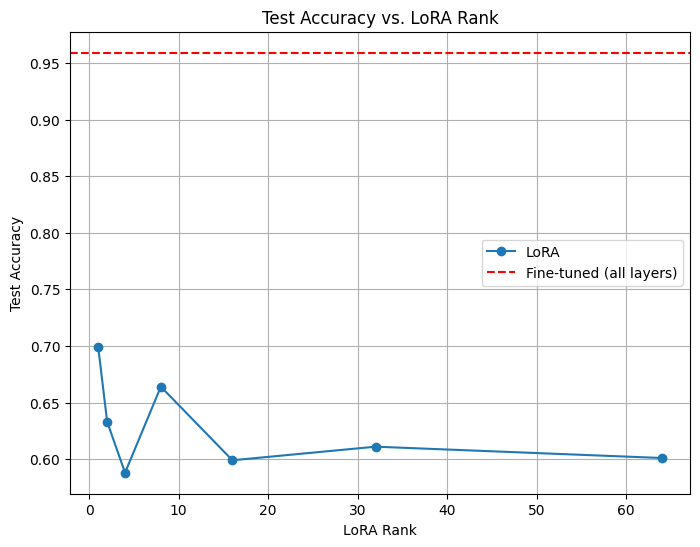

LoRA Rank 1: 6789 parameters added
LoRA Rank 2: 13578 parameters added
LoRA Rank 4: 27156 parameters added
LoRA Rank 8: 54312 parameters added
LoRA Rank 16: 108624 parameters added
LoRA Rank 32: 217248 parameters added
LoRA Rank 64: 434496 parameters added


In [36]:
lora_ranks = [1, 2, 4, 8, 16, 32, 64]
lora_test_accuracies = []
lora_params_counts = []

for rank in lora_ranks:
    print(f"Fine-tuning with LoRA rank {rank}")
    
    # Create a new instance of the modified network with the current LoRA rank
    modified_net = ModifiedClassifier(rank).to(device)
    
    # Fine-tune the model with the current LoRA rank
    train_loss_lst_lora, val_loss_lst_lora = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)
    
    # Compute test accuracy on MNIST 5...9 for the current LoRA rank
    wrong_counts_subset2_lora = {i: 0 for i in range(5, 10)}
    accuracy_subset2_lora = test(test_loader_subset2, "Testing subset2", modified_net, wrong_counts_subset2_lora)
    lora_test_accuracies.append(accuracy_subset2_lora)
    
    # Count the number of parameters introduced by LoRA layers
    lora_params_count = count_lora_parameters(modified_net)
    lora_params_counts.append(lora_params_count)
    
    print(f"Test accuracy on MNIST 5...9 for LoRA rank {rank}: {accuracy_subset2_lora}")
    print(f"Number of parameters introduced by LoRA rank {rank}: {lora_params_count}")
    print("---")

# Plot the test accuracy as a function of LoRA rank
plt.figure(figsize=(8, 6))
plt.plot(lora_ranks, lora_test_accuracies, marker='o', label='LoRA')
plt.axhline(accuracy_finetuned_all, color='r', linestyle='--', label='Fine-tuned (all layers)')
plt.xlabel('LoRA Rank')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. LoRA Rank')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of parameters added by each LoRA rank
for rank, params_count in zip(lora_ranks, lora_params_counts):
    print(f"LoRA Rank {rank}: {params_count} parameters added")

Result analysis:
The graph shows that LoRA achieves the highest accuracy (around 0.70) at rank 1, and increasing the rank further leads to lower but more stable accuracy (around 0.60).

We think that it could be due to:
- Overfitting: More parameters added and to train
- Insufficient training data: Tha finetune dataset may be too small to train high rank LoRA
- Optimization problem: The optimization algo may struggle to find best solution

Here are a few key pros of LoRA and potential applications we envision:

**Pros:**
- Adds only a small number of parameters, reducing memory usage
- Enables faster fine-tuning by updating only LoRA parameters  
- Preserves valuable pre-trained knowledge in frozen base model
- Allows flexibility in balancing added parameters vs adaptation capacity

**Applications:**
- Adapting models to specialized domains (e.g. medical images)
- Personalizing models for individual users/preferences
- Learning from limited labeled data by leveraging pre-trained models 
- Continual learning to incrementally adapt to new tasks
- Compressing large models while retaining performance
